# Final Project - Team 9 
### Authors: Craig Nathan, Thomas Tran, Zohaib Shahid
###### AAI 695-WS2 | Spring 2023


---

# CPE/EE/AAI 695-WS2  |  Final Project | Team 9
# Game Recommendations on Steam
### Authors: Craig Nathan, Thomas Tran, Zohaib Shahid

Steam is a video game digital distriburtion service and storefront where users can purchase and play games. The purpose of this project is to construct a Recommender System (RS) to predict the top-k unplayed games for a user based user history, users with similar tastes in genres, and games with similar genres to those the user likes.

We use a [dataset from Kaggle](https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam). The dataset consists of three CSV files. This includes a file titled ‘Games’ contains titles of games and purchasable game content, ratings, price in USD, and release dates, a ‘Users’ CSV containing information regarding the users who have reviewed the games in the ‘Games’ CSV, and a ‘Recommendations’ CSV, which offers whether a user recommends the product they reviewed. Note that personal user information is not accessible within the files.

After exploring the data, we identify several challenges and methods we can use to overcome them.

## Set Up Environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
import sys
import IPython
import psutil
import os

In [2]:
# Set the project directory correctly for colab and jupyter environments
try:
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_DIR = '/content/drive/MyDrive/AAI-695/Final-Project/' # Google Drive project directory
except ImportError:
    PROJECT_DIR = os.getcwd() # Jupyter Notebook project directory

# Set filename and path variables (used to save notebook fuctions into .py file for other notebooks to access - last step)
NOTEBOOK_NAME = "data_preprocessing"
NOTEBOOK_PATH = os.path.join(PROJECT_DIR, NOTEBOOK_NAME + '.ipynb')
FUNCTIONS_DIR = os.path.join(PROJECT_DIR, 'functions/')
DATA_DIR =      os.path.join(PROJECT_DIR, 'data/')

# Add the Functions module directory to the Python path
sys.path.append(FUNCTIONS_DIR)

Mounted at /content/drive


In [3]:
# Import functions file (ignore pylance warning)
import utility_funcs as util

# Note: Any changes to imported function files requires Runtime Restart

## Load Data

Mount Google Drive to the Colab environment:

In [4]:
def load_data(dir):

  # Read in data files
  df_games = pd.read_csv(dir + 'games.csv')
  df_users = pd.read_csv(dir + 'users.csv')
  df_recs = pd.read_csv(dir + 'recommendations.csv')
  df_games_meta = pd.read_json(dir + 'games_metadata.json', lines=True, orient="records")

  # Perform a left join on the games and games_meta dataframes using the 'app_id' column
  df_games = df_games.merge(df_games_meta, on='app_id', how='left')

  # Rename certain columns for readability
  df_games.rename(columns = {'positive_ratio':'rating_positive_ratio', 'user_reviews':'game_review_count'}, inplace = True)
  df_users.rename(columns = {'products':'games_played', 'reviews':'user_review_count'}, inplace = True)
  df_recs.rename(columns = {'hours':'hours_played'}, inplace = True)
  
  # Organize dataframes into a dictionary for easy access
  steam_data = {'games': df_games, 'users': df_users, 'recs': df_recs}
      
  return steam_data

# Function call
steam_data = load_data(DATA_DIR)


In [5]:
# Unpack dataframes from dictionary of dataframes
def unpack_dict(data_dict):
  return data_dict['games'], data_dict['users'], data_dict['recs']

# Function call
df_games, df_users, df_recs = unpack_dict(steam_data)

## Explore the Data
By performing data cleaning, preprocessing, and exploration on the entire dataset first, we ensure that both the training and test sets have similar data distributions and characteristics, which is important for reliable model evaluation. These initial steps can also reveal insights into the dataset, and help to make informed decisions on how to best preprocess the data and engineer features.

Once the entire dataset has been cleaned and preprocessed, we split it into training and test sets. This helps to prevent data leakage and ensures that any transformations applied to the data during feature engineering are consistent across both sets. Data leakage can occur when information from the test set is used, directly or indirectly, during the training process, which can lead to overfitting and overly optimistic performance estimates.

In [6]:
df_games.head()

,app_id,title,date_release,win,mac,linux,rating,rating_positive_ratio,game_review_count,price_final,price_original,discount,steam_deck,description,tags
0,10090,Call of Duty: World at War,2008-11-18,True,False,False,Very Positive,92,37039,19.99,19.99,0.0,True,"Call of Duty is back, redefining war like you'...","[Zombies, World War II, FPS, Multiplayer, Acti..."
1,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
2,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True,,[Action]
3,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
4,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."


In [7]:
df_users.head()

,user_id,games_played,user_review_count
0,5693478,156,1
1,3595958,329,3
2,1957593,176,2
3,2108293,98,2
4,2329878,144,2


In [8]:
df_recs.head()

,app_id,helpful,funny,date,is_recommended,hours_played,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,19954,0
1,304390,4,0,2017-02-17,False,11.5,1098,1
2,1085660,2,0,2019-11-17,True,336.5,91207,2
3,703080,0,0,2022-09-23,True,27.4,93054,3
4,526870,0,0,2021-01-10,True,7.9,9106,4


In [9]:
print(f'{df_games.info()}\n')
print(f'{df_users.info()}\n')
print(f'{df_recs.info()}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46068 entries, 0 to 46067
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   app_id                 46068 non-null  int64  
 1   title                  46068 non-null  object 
 2   date_release           46068 non-null  object 
 3   win                    46068 non-null  bool   
 4   mac                    46068 non-null  bool   
 5   linux                  46068 non-null  bool   
 6   rating                 46068 non-null  object 
 7   rating_positive_ratio  46068 non-null  int64  
 8   game_review_count      46068 non-null  int64  
 9   price_final            46068 non-null  float64
 10  price_original         46068 non-null  float64
 11  discount               46068 non-null  float64
 12  steam_deck             46068 non-null  bool   
 13  description            46068 non-null  object 
 14  tags                   46068 non-null  object 
dtypes:

<b>Note:</b> In the games DataFrame, we have one useful categorical column - reviews. If we use this we'll want to use a one-hot encoder after splitting the data into train and test sets.

In [10]:
# Total count of NaN values
if df_games.isnull().sum().sum() > 0: print(f'Null values in df_games: {df_games.isnull().sum().sum()}')
if df_users.isnull().sum().sum() > 0: print(f'Null values in df_games: {df_users.isnull().sum().sum()}')
if df_recs.isnull().sum().sum() > 0: print(f'Null values in df_games: {df_recs.isnull().sum().sum()}')

In [11]:
# Print sorted ratings and their counts
def print_rating_cats(df_games):
    
  # Build dataframe of categories
  cat_counts_df = df_games['rating'].value_counts().reset_index().rename(columns={'index': 'rating', 'rating': 'count'})

  # Define the desired sorting order
  SORT_ORDER  = ['Overwhelmingly Positive', 'Very Positive', 'Mostly Positive', 'Positive', 'Mixed', 
                  'Negative', 'Mostly Negative', 'Very Negative', 'Overwhelmingly Negative']

  # Create a categorical data type with the specified order
  cat_dtype = pd.CategoricalDtype(categories=SORT_ORDER, ordered=True)

  # Convert the 'rating' column to the categorical data type
  cat_counts_df['rating'] = cat_counts_df['rating'].astype(cat_dtype)

  # Sort the DataFrame by the 'rating' column
  sorted_df = cat_counts_df.sort_values(by='rating')

  # Print unique categories sorted best-to-worst
  print(f'There are {len(cat_counts_df)} rating categories:')
  display(sorted_df.style.hide(axis='index'))

  return
    
# Function call
print_rating_cats(df_games)

There are 9 rating categories:


rating,count
Overwhelmingly Positive,1045
Very Positive,12276
Mostly Positive,8068
Positive,11417
Mixed,11194
Negative,280
Mostly Negative,1723
Very Negative,52
Overwhelmingly Negative,13


In [12]:
df_games.describe()

,app_id,rating_positive_ratio,game_review_count,price_final,price_original,discount
count,4.606800e+04,46068.000000,4.606800e+04,46068.000000,46068.000000,46068.000000
mean,9.864431e+05,76.757988,1.843201e+03,8.750796,9.299008,5.185291
std,5.670487e+05,18.195317,3.908656e+04,11.364319,11.668360,18.190569
min,1.000000e+01,0.000000,1.000000e+01,0.000000,0.000000,0.000000
25%,5.017228e+05,66.000000,2.000000e+01,1.382500,1.990000,0.000000
50%,9.162850e+05,81.000000,5.300000e+01,4.990000,5.990000,0.000000
75%,1.422158e+06,91.000000,2.260000e+02,11.990000,12.990000,0.000000
max,2.319990e+06,100.000000,6.941137e+06,299.990000,299.990000,90.000000


In [13]:
df_users.describe()

,user_id,games_played,user_review_count
count,5.810794e+06,5.810794e+06,5.810794e+06
mean,2.905396e+06,1.322544e+02,1.733372e+00
std,1.677432e+06,2.623620e+02,1.999447e+00
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.452698e+06,2.300000e+01,1.000000e+00
50%,2.905396e+06,6.200000e+01,1.000000e+00
75%,4.358095e+06,1.510000e+02,2.000000e+00
max,5.810793e+06,2.930800e+04,1.510000e+02


In [14]:
df_recs.describe()

,app_id,helpful,funny,hours_played,user_id,review_id
count,1.007227e+07,1.007227e+07,1.007227e+07,1.007227e+07,1.007227e+07,1.007227e+07
mean,6.219670e+05,3.287714e+00,1.161575e+00,1.585668e+02,2.986138e+06,5.036134e+06
std,4.830838e+05,5.683120e+01,4.119607e+01,2.153311e+02,1.663607e+06,2.907614e+06
min,7.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.647100e+05,0.000000e+00,0.000000e+00,1.960000e+01,1.594016e+06,2.518067e+06
50%,4.319600e+05,0.000000e+00,0.000000e+00,6.330000e+01,3.032317e+06,5.036134e+06
75%,1.057090e+06,0.000000e+00,0.000000e+00,2.011000e+02,4.439388e+06,7.554202e+06
max,2.208920e+06,3.621200e+04,2.808800e+04,9.999000e+02,5.810793e+06,1.007227e+07


#### Plot a histogram of each numerical attribute

###### Recommendation Data:

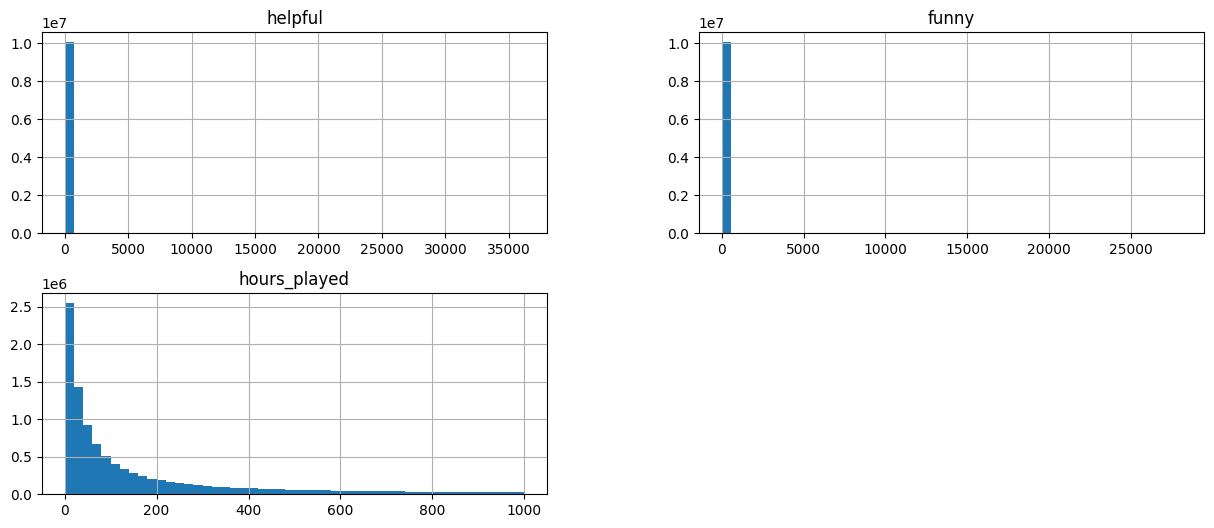

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
selected_columns = [col for col in steam_data['recs'].columns if col not in ['app_id', 'user_id', 'review_id']]
df_recs[selected_columns].hist(bins=50, figsize=(15,6))
plt.show()

###### User Data:

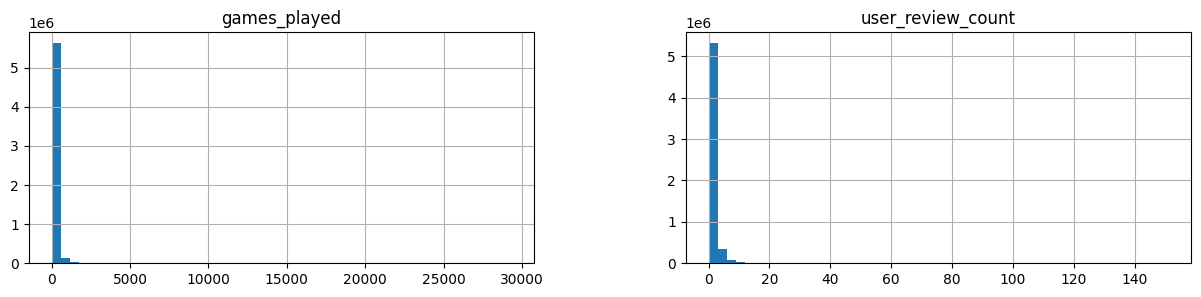

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
selected_columns = [col for col in df_users.columns if col not in ['user_id']]
df_users[selected_columns].hist(bins=50, figsize=(15,3))
plt.show()

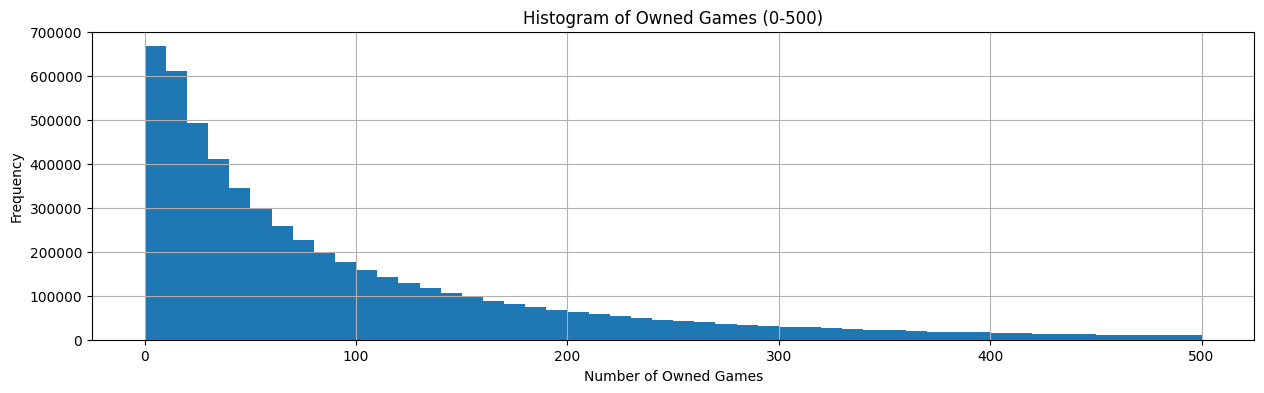

In [17]:
df_users[df_users['games_played'] <= 500].hist(column='games_played', bins=50, figsize=(15, 4))
plt.xlabel('Number of Owned Games')
plt.ylabel('Frequency')
plt.title('Histogram of Owned Games (0-500)')
plt.show()

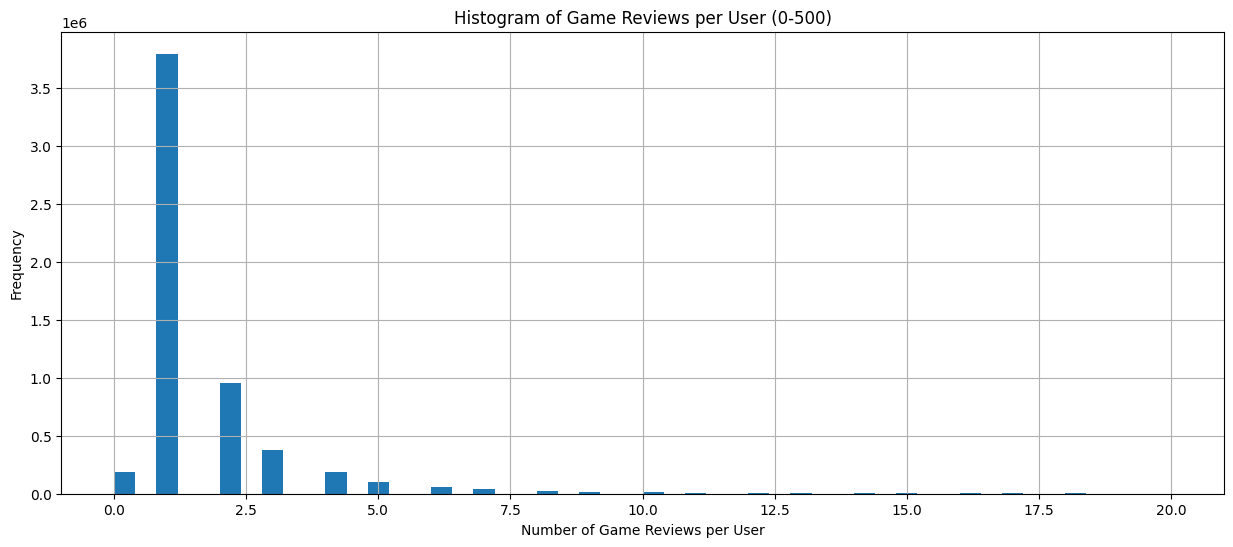

In [18]:
df_users[df_users['user_review_count'] <= 20].hist(column='user_review_count', bins=50, figsize=(15, 6))
plt.xlabel('Number of Game Reviews per User')
plt.ylabel('Frequency')
plt.title('Histogram of Game Reviews per User (0-500)')
plt.show()

__Note__: It appears that we have a highly skewed distribution of game reviews per in our dataset, with most users having very few reviews. A highly skewed distribution of user reviews could have several implications for our machine learning models, especially for collaborative filtering models:
- __Data sparsity:__ In a highly skewed distribution, most users have only interacted with a few items, leading to a very sparse user-item matrix. This sparsity makes it difficult to find similar users or items based on their interactions, as there is limited data to draw similarities from. As a result, the quality of recommendations may suffer, and the system may struggle to provide accurate and diverse recommendations. This may call for more complex techniques, such as matrix factorization or hybrid models, to improve recommendations
- __Cold start problem:__ The cold start problem arises when there is not enough information about new users or items to make accurate recommendations. The same issue becomes apparent for users who have provided very few reviews; they may not receive accurate recommendations because their preferences have not been fully captured. Similarly, games with very few or no reviews will be difficult for the model to provide recommendations for, as there is limited information available about those items. 
- __Popularity bias:__ Collaborative filtering models already suffer from popularity bias, where the recommendation system tends to recommend popular items with many interactions, while less popular items with fewer interactions are overlooked. Since our dataset has a highly skewed distribution user user reviews, this issue may become more pronounced. This may lead to a lack of diversity in the recommendations.

These challenges can affect the performance of our recommendation system, particularly if we use a collaborative filtering model, which relies on the relationships between users and items based on their interactions. Addressing these challenges may require incorporating additional information, such as content-based features, or using techniques like matrix factorization to help overcome the sparsity and cold start issues. Lets finished exploring the game data before proposing some solutions.

###### Game Data:

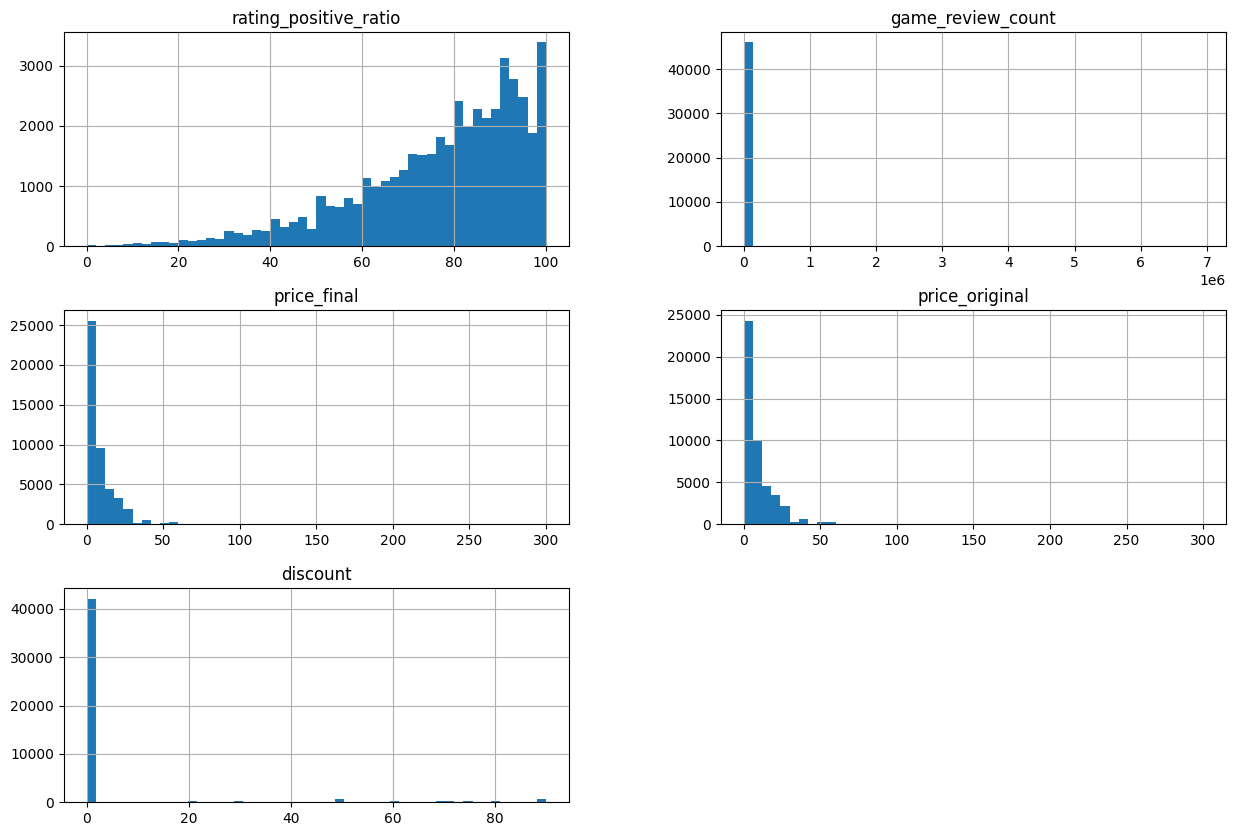

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
selected_columns = [col for col in df_games.columns if col not in ['app_id']]
df_games[selected_columns].hist(bins=50, figsize=(15,10))
plt.show()

The histogram of user_reviews is skewed to the left. To better understand this distribution, we use descriptive statistics and zoom in on the lower end of the distribution:

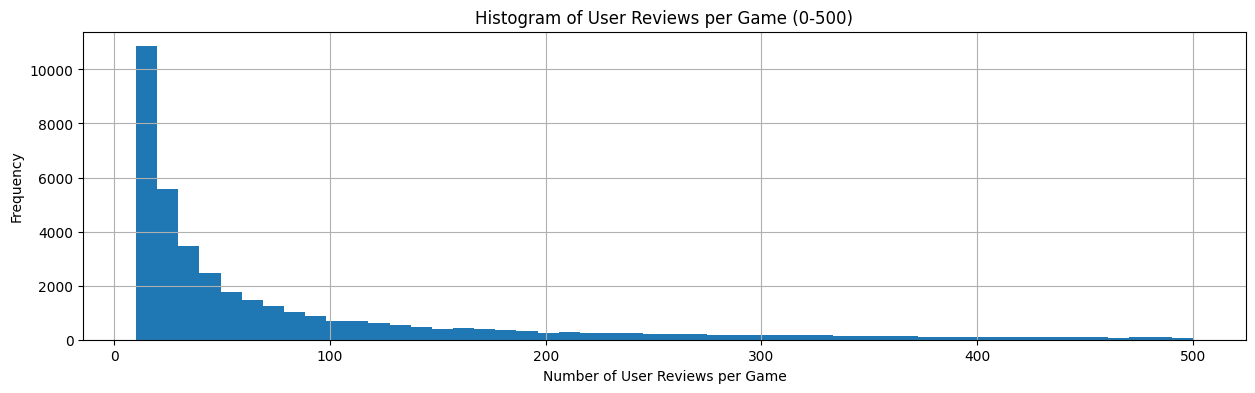

In [20]:
df_games[df_games['game_review_count'] <= 500].hist(column='game_review_count', bins=50, figsize=(15, 4))
plt.xlabel('Number of User Reviews per Game')
plt.ylabel('Frequency')
plt.title('Histogram of User Reviews per Game (0-500)')
plt.show()

In [21]:
percentiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
for percentile in percentiles:
    value = df_games['game_review_count'].quantile(percentile)
    print(f'{percentile * 100}% percentile: {value}')

10.0% percentile: 13.0
25.0% percentile: 20.0
50.0% percentile: 53.0
75.0% percentile: 226.0
90.0% percentile: 1186.0
95.0% percentile: 3425.600000000006
99.0% percentile: 26672.780000000115


__Note:__ It appears that we also have a highly skewed distribution of number of game reviews per user in our dataset. Since both the number of game reviews per user and the number of reviews per game are highly skewed, the issues discussed above may be compounded; increased data sparcity, worse cold start problems, higher sensitivity to noise, and diminished diversity. This reinforces the importance of mitigating these issues.

Despite the challenges presented by skewed and sparse data, collaborative filtering it can still be worth pursuing as it has been successful in various real-world recommendation systems. To address overcome these challenges, we will consider a number of the following alternatives or complementary approaches:

- __Data preprocessing:__ We will filter out games with zero or very few reviews and users who have provided zero or very few reviews to reduce sparsity in the dataset. However, this can lead to a smaller dataset and may not solve the cold start problem. However, it will alleviate some of the memory issues we have been encountering when creating the user-item matrix, since there are nearly 5 million users the user-item matrix. Without any preprocessing, the user-item matrix would exceed 64GB and the resources available to us.
- __Neighborhood size tuning:__ Neighborhood size tuning is a technique used in collaborative filtering to optimize the performance of the model by selecting an optimal number of similar users or items to consider when making recommendations. In user-based collaborative filtering, the model identifies users with similar preferences and recommends items that those similar users liked. In item-based collaborative filtering, the model identifies items that are similar to the ones the user has interacted with, and recommends those similar items. The neighborhood size is the number of similar users or items considered during this process. Selecting an appropriate neighborhood size is crucial, as a small neighborhood may lead to less accurate recommendations, while a large neighborhood can result in increased computational complexity and the possibility of incorporating less relevant information. To tune the neighborhood size, one can evaluate the model performance with different neighborhood sizes and choose the size that results in the best balance between accuracy and computational efficiency. This can help in addressing the challenges caused by sparse and skewed data in collaborative filtering models. _[Sarwar, B. M., Karypis, G., Konstan, J. A., & Riedl, J. (2001). Item-based collaborative filtering recommendation algorithms. Proceedings of the 10th International Conference on World Wide Web, 285-295. DOI: 10.1145/371920.372071]_
- __Content-based filtering:__ Content-based filtering is a recommendation approach that utilizes features of items to make recommendations, rather than relying on past user behavior. This approach focuses on the item's attributes and a user's preference for these attributes to make recommendations. It analyzes item features (e.g., genre, director, actors, etc., for movies) and matches them to the user's preferences based on their past interactions with items. For new items with limited interaction data, the recommendation system can still make predictions by comparing the features of these items to the preferences of the user.
- __Matrix factorization techniques:__ We will use matrix factorization techniques like Singular Value Decomposition (SVD) or Alternating Least Squares (ALS) to uncover latent features in the data and provide better recommendations, even with sparse data.
- __Diversification:__ Include methods to diversify recommendations, such as diversity-promoting algorithms, in order to counteract the popularity bias.
- __Weighted approaches:__ Utilize inverse user frequency (IUF) or inverse item frequency (IIF) to adjust the importance of different users or items in the model.
- __Testing different algorithms:__ Experiment with different collaborative filtering algorithms, including user-based, item-based, or more advanced methods like matrix factorization, to determine which one works best with our data.
- __Hybrid models:__ Combine collaborative filtering with other approaches, such as content-based filtering or deep learning models, to improve recommendation performance and mitigate the impact of skewed data.

## Data Cleaning

### Filtering - Remove Irrelevant Data
Certain data does not contribute significantly to the model and can be removed:
1. <u>__Reviews from Users with Zero Playtime__</u> - Reviews from users who have not actually played the game might not provide genuine feedback about the game's quality or characteristics. These reviews may be based on external factors or assumptions, which could negatively impact the performance of recommendation models. By removing such reviews, we ensure that the remaining reviews are more likely to be based on actual user experiences.
2. <u>__Reviews from Users with Zero Games__</u> - Users with zero games in their library might not be real users or could be newly created accounts with limited or no experience in the gaming platform. Their reviews might be less informative and less representative of the overall user base. Removing these reviews can help ensure that the dataset consists of more experienced and engaged users, which could lead to more reliable and accurate recommendations.
3. <u>__Reviews for Games with Few Players/Reviews__</u> - Games with few players might be niche games that are not very popular. By removing these games, we focus on more popular games that might have more widespread appeal. This step can help reduce noise in the data by focusing on games with more substantial user engagement. This is important for getting reliable recommendations and improving model performance.
4. <u>__Reviews from Users with Few Games__</u> - Users who have played only a few games might not have diverse preferences. Removing these reviews can help us focus on users who have a more extensive gaming history and are likely to have more diverse preferences.
5. <u>__Reviews from Users with Few Reviews__</u> - Users who have left only a few reviews may not provide enough information to accurately model their preferences. Removing these reviews can help us focus on users who are more engaged and who have provided more feedback, which can help improve the recommendations.

This order prioritizes removing reviews that are likely to be least informative or relevant, such as those from users with zero playtime or zero games. Next, it focuses on filtering out games with low popularity or fewer reviews to reduce the impact of the long tail in the distribution. Finally, it addresses users with few played games or few reviews to further refine the dataset.

### Calculate Density of User-Item Matrix before and after filtering

In [22]:
def calculate_density(df):
  n_users = df['user_id'].nunique()
  n_items = df['app_id'].nunique()
  n_non_zero_elements = df.shape[0]
  density = n_non_zero_elements / (n_users * n_items)
  density_percentage = density * 100
  print(f'User-Item Matrix Density (%): {round(density_percentage,4)}%\n')
  return

# Function call
calculate_density(df_recs)

User-Item Matrix Density (%): 0.2511%



In [23]:
# Calculate and print density and remaining percentages
def print_stats(df_games, df_users, df_recs, filtered_games, filtered_users, filtered_recs):
    perc_games_remaining = len(filtered_games) / len(df_games) * 100
    perc_users_remaining = len(filtered_users) / len(df_users) * 100
    perc_recs_remaining = len(filtered_recs) / len(df_recs) * 100

    print(f"Games remaining (%):\t {perc_games_remaining:.2f}%")
    print(f"Users remaining (%):\t {perc_users_remaining:.2f}%")
    print(f"Reviews remaining (%):\t {perc_recs_remaining:.2f}%\n")
    calculate_density(filtered_recs)
    return

In [24]:
# df_games_filt = df_games.copy()
# df_users_filt = df_users.copy()
# df_recs_filt = df_recs.copy()

steam_data_pre = steam_data.copy()

### 1. Remove Reviews from Users with Zero Playtime
The "Hours" feature is the number of hours played by the user who made the recommendation. A value of zero means the user has not played the game.

In [25]:
def filter_1(data_orig, data, verbose=True):
    
    # Separate dataframes for easier access within funcion
    df_games, df_users, df_recs = data_orig['games'], data_orig['users'], data_orig['recs']
    df_games_pre, df_users_pre, df_recs_pre = data['games'], data['users'], data['recs']
    
    # Find user_ids of users with zero playtime
    user_ids_zero_playtime = df_recs_pre[df_recs_pre['hours_played'] == 0]['user_id'].unique()

    # Filter df_users, df_games, and df_recs
    df_games_filt = df_games_pre
    df_recs_filt = df_recs_pre[~df_recs_pre['user_id'].isin(user_ids_zero_playtime)]
    df_users_filt = df_users_pre[~df_users_pre['user_id'].isin(user_ids_zero_playtime)]
    
    if verbose:
        print(f"Filter 1: Keep Reviews from Users with more than 0 hours of playtime\n")
        print_stats(df_games, df_users, df_recs, df_games_filt, df_users_filt, df_recs_filt)
    
    # Join dataframes back into dictionary (easier for passing between functions)
    steam_data_filt = {'games': df_games_filt, 'users': df_users_filt, 'recs': df_recs_filt}
    
    return steam_data_filt
        
steam_data_filt = filter_1(steam_data, steam_data_pre)

Filter 1: Keep Reviews from Users with more than 0 hours of playtime

Games remaining (%):	 100.00%
Users remaining (%):	 99.99%
Reviews remaining (%):	 99.98%

User-Item Matrix Density (%): 0.251%



### 2. Remove Reviews from Users with Zero Games:

In [26]:
def filter_2(data_orig, data, verbose=True):
    
    # Separate dataframes for easier access within funcion
    df_games, df_users, df_recs = data_orig['games'], data_orig['users'], data_orig['recs']
    df_games_pre, df_users_pre, df_recs_pre = data['games'], data['users'], data['recs']
    
    # Find user_ids of users with zero products
    user_ids_zero_products = df_users_pre[df_users_pre['games_played'] == 0]['user_id'].unique()

    # Filter df_users, df_games, and df_recs
    df_games_filt = df_games_pre
    df_recs_filt = df_recs_pre[~df_recs_pre['user_id'].isin(user_ids_zero_products)]
    df_users_filt = df_users_pre[~df_users_pre['user_id'].isin(user_ids_zero_products)]
    
    if verbose:
        print(f"Filter 2: Keep Reviews from Users with more than 0 Games\n")
        print_stats(df_games, df_users, df_recs, df_games_filt, df_users_filt, df_recs_filt)

    # Join dataframes back into dictionary (easier for passing between functions)
    steam_data_filt = {'games': df_games_filt, 'users': df_users_filt, 'recs': df_recs_filt}
    
    return steam_data_filt
        
steam_data_filt = filter_2(steam_data, steam_data_filt)

Filter 2: Keep Reviews from Users with more than 0 Games

Games remaining (%):	 100.00%
Users remaining (%):	 98.66%
Reviews remaining (%):	 99.28%

User-Item Matrix Density (%): 0.2524%



### 3. Remove Reviews for Games with Few Reviews
Plot the cumulative percentage of games (y-axis) against the number of reviews per game (x-axis). Then find the elbow point in the plot, where adding more games with fewer reviews has diminishing returns.

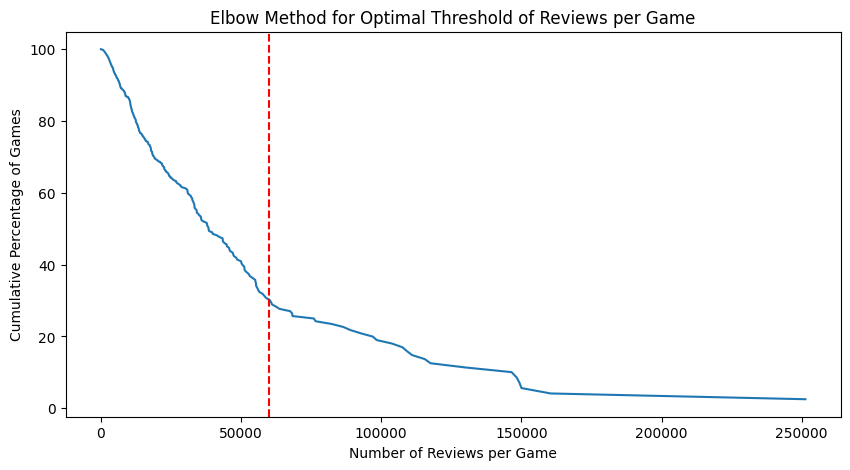

Filter 3: Keep Reviews for Games with more than 60000 reviews

Games remaining (%):	 0.47%
Users remaining (%):	 98.66%
Reviews remaining (%):	 29.90%

User-Item Matrix Density (%): 4.3024%

Minimum number of reviews per game: 60241



In [27]:
def filter_3(data_orig, data, threshold=60000, verbose=True, show_plots=True):
    
    # Separate dataframes for easier access within funcion
    df_games, df_users, df_recs = data_orig['games'], data_orig['users'], data_orig['recs']
    df_games_pre, df_users_pre, df_recs_pre = data['games'], data['users'], data['recs']
    
    # Calculate the number of reviews for each game and cumulative percentage of games
    game_review_counts = df_recs_pre['app_id'].value_counts().sort_values(ascending=False)
    cumulative_percent_games = np.cumsum(game_review_counts) / game_review_counts.sum() * 100

    # Plot the cumulative percentage of games against the number of reviews per game
    if show_plots:
        plt.figure(figsize=(10, 5))
        plt.plot(game_review_counts.values, cumulative_percent_games)
        plt.axvline(x=threshold, color='r', linestyle='--')
        plt.xlabel('Number of Reviews per Game')
        plt.ylabel('Cumulative Percentage of Games')
        plt.title('Elbow Method for Optimal Threshold of Reviews per Game')
        plt.show()

    # Filter out games and reviews based on the filtered game IDs
    df_games_filt = df_games_pre[df_games_pre['game_review_count'] >= threshold]
    df_users_filt = df_users_pre
    df_recs_filt = df_recs_pre[df_recs_pre['app_id'].isin(df_games_filt['app_id'])]
    
    # Filter to only include games with threshold or more reviews
    game_review_counts = df_recs_filt.groupby('app_id').size()
    games_to_keep = game_review_counts[game_review_counts >= threshold].index    
    df_recs_filt = df_recs_filt[df_recs_filt['app_id'].isin(games_to_keep)]
    
    if verbose:
        print(f"Filter 3: Keep Reviews for Games with more than {threshold} reviews\n")
        print_stats(df_games, df_users, df_recs, df_games_filt, df_users_filt, df_recs_filt)
        print(f"Minimum number of reviews per game: {df_recs_filt.groupby('app_id').size().min()}\n")

    # Join dataframes back into dictionary (easier for passing between functions)
    steam_data_filt = {'games': df_games_filt, 'users': df_users_filt, 'recs': df_recs_filt}
    
    return steam_data_filt
        
steam_data_filt = filter_3(steam_data, steam_data_filt)

### 4. Remove Reviews from Users with Few Games
Plot the cumulative percentage of games (y-axis) against the number of reviews per game (x-axis). Then find the elbow point in the plot, where adding more games with fewer reviews has diminishing returns.

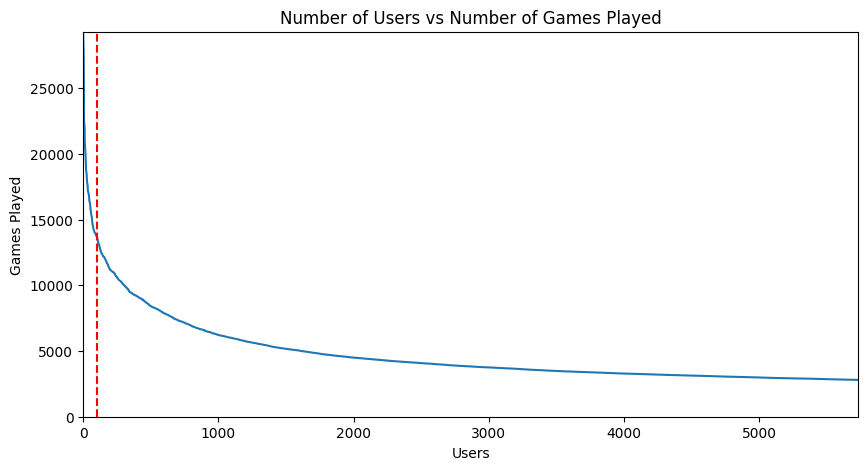

Filter 4: Keep Reviews from Users with more than 100 games

Games remaining (%):	 0.47%
Users remaining (%):	 36.46%
Reviews remaining (%):	 12.53%

User-Item Matrix Density (%): 4.8247%

Minimum number of games per user: 100



In [28]:
def filter_4(data_orig, data, threshold=100, verbose=True, show_plots=True):
    
    # Separate dataframes for easier access within funcion
    df_games, df_users, df_recs = data_orig['games'], data_orig['users'], data_orig['recs']
    df_games_pre, df_users_pre, df_recs_pre = data['games'], data['users'], data['recs']
    
    # Sort and plot the number of users vs the number of games/products
    df_users_sorted = df_users_pre.sort_values(by='games_played', ascending=False).reset_index(drop=True)

    # Plot the number of users vs the number of games/products
    if show_plots:
        plt.figure(figsize=(10, 5))
        plt.plot(df_users_sorted.index, df_users_sorted['games_played'])
        plt.axvline(x=threshold, color='r', linestyle='--')
        plt.title('Number of Users vs Number of Games Played')
        plt.xlabel('Users')
        plt.ylabel('Games Played')
        plt.xlim(0, len(df_users_sorted)/1000)
        plt.ylim(0, df_users_sorted['games_played'].max())
        plt.show()

    # Filter df_users, df_games, and df_recs
    df_games_filt = df_games_pre
    df_users_filt = df_users_pre[df_users_pre['games_played'] >= threshold]
    df_recs_filt = df_recs_pre[df_recs_pre['user_id'].isin(df_users_filt['user_id'])]
    
    if verbose:
        print(f"Filter 4: Keep Reviews from Users with more than {threshold} games\n")
        print_stats(df_games, df_users, df_recs, df_games_filt, df_users_filt, df_recs_filt)
        print(f"Minimum number of games per user: {df_users_filt['games_played'].min()}\n")

    # Join dataframes back into dictionary (easier for passing between functions)
    steam_data_filt = {'games': df_games_filt, 'users': df_users_filt, 'recs': df_recs_filt}
    
    return steam_data_filt
        
steam_data_filt = filter_4(steam_data, steam_data_filt)

### 5. Remove Reviews from Users with Few Reviews

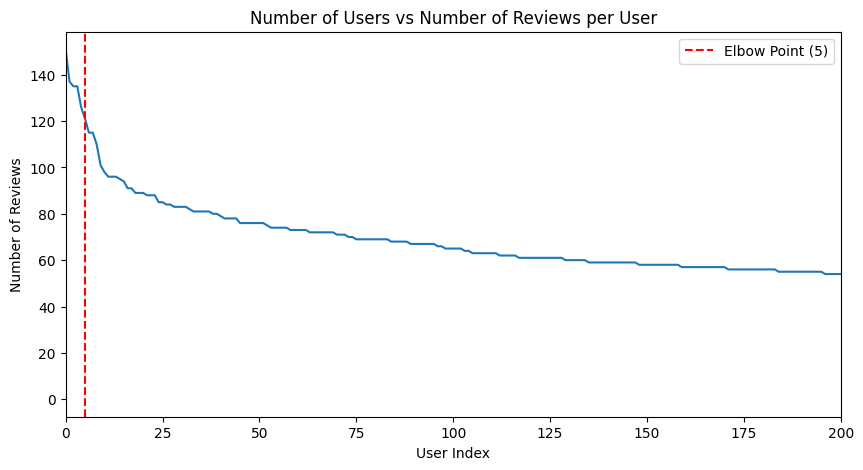

Filter: Keep Reviews from Users with more than 5 Reviews

Games remaining (%):	 0.47%
Users remaining (%):	 3.98%
Reviews remaining (%):	 0.81%

User-Item Matrix Density (%): 20.3939%

Minimum number of reviews for any user: 5



In [29]:
def filter_5(data_orig, data, threshold=5, verbose=True, show_plots=True):
    
    # Separate dataframes for easier access within funcion
    df_games, df_users, df_recs = data_orig['games'], data_orig['users'], data_orig['recs']
    df_games_pre, df_users_pre, df_recs_pre = data['games'], data['users'], data['recs']

    # Sort users by the number of reviews
    df_users_sorted = df_users_pre.sort_values(by='user_review_count', ascending=False).reset_index(drop=True)

    # Plot the number of users vs number of reviews per user
    if show_plots:
        plt.figure(figsize=(10, 5))
        plt.plot(df_users_sorted['user_review_count'])
        plt.axvline(x=threshold, color='red', linestyle='--', label=f'Elbow Point ({threshold})')
        plt.title('Number of Users vs Number of Reviews per User')
        plt.xlabel('User Index')
        plt.ylabel('Number of Reviews')
        plt.legend()
        plt.xlim(0, 200)
        plt.show()

    # Filter df_users, df_games, and df_recs
    df_games_filt = df_games_pre
    df_users_filt = df_users_pre[df_users_pre['user_review_count'] >= threshold]
    df_recs_filt = df_recs_pre[df_recs_pre['user_id'].isin(df_users_filt['user_id'])]

    # Group by user_id and count the number of reviews for each user
    user_review_counts = df_recs_filt.groupby('user_id').size()

    # Filter out users with less than threshold reviews
    users_to_keep = user_review_counts[user_review_counts >= threshold].index

    # Filter the df_recs_filt DataFrame to only include users with threshold or more reviews
    df_recs_filt = df_recs_filt[df_recs_filt['user_id'].isin(users_to_keep)]
    
    if verbose:
        print(f"Filter: Keep Reviews from Users with more than {threshold} Reviews\n")
        print_stats(df_games, df_users, df_recs, df_games_filt, df_users_filt, df_recs_filt)
        print(f"Minimum number of reviews for any user: {df_recs_filt.groupby('user_id').size().min()}\n")
        
    # Join dataframes back into dictionary (easier for passing between functions)
    steam_data_filt = {'games': df_games_filt, 'users': df_users_filt, 'recs': df_recs_filt}
    
    return steam_data_filt
        
steam_data_filt = filter_5(steam_data, steam_data_filt)

1. <u>__Reviews from Users with Zero Playtime__</u> - Reviews from users who have not actually played the game might not provide genuine feedback about the game's quality or characteristics. These reviews may be based on external factors or assumptions, which could negatively impact the performance of recommendation models. By removing such reviews, we ensure that the remaining reviews are more likely to be based on actual user experiences.
2. <u>__Reviews from Users with Zero Games__</u> - Users with zero games in their library might not be real users or could be newly created accounts with limited or no experience in the gaming platform. Their reviews might be less informative and less representative of the overall user base. Removing these reviews can help ensure that the dataset consists of more experienced and engaged users, which could lead to more reliable and accurate recommendations.
3. <u>__Reviews for Games with Few Players/Reviews__</u> - Games with few players might be niche games that are not very popular. By removing these games, we focus on more popular games that might have more widespread appeal. This step can help reduce noise in the data by focusing on games with more substantial user engagement. This is important for getting reliable recommendations and improving model performance.
4. <u>__Reviews from Users with Few Games__</u> - Users who have played only a few games might not have diverse preferences. Removing these reviews can help us focus on users who have a more extensive gaming history and are likely to have more diverse preferences.
5. <u>__Reviews from Users with Few Reviews__</u> - Users who have left only a few reviews may not provide enough information to accurately model their preferences. Removing these reviews can help us focus on users who are more engaged and who have provided more feedback, which can help improve the recommendations.

In [30]:
# # Randomly sample a percentage of remaining data
# def filter_6(data_orig, data, perc=1, verbose=True):
    
#     # Separate dataframes for easier access within function
#     df_games, df_users, df_recs = data_orig['games'], data_orig['users'], data_orig['recs']
#     df_games_pre, df_users_pre, df_recs_pre = data['games'], data['users'], data['recs']
    
#     # Filter
#     df_recs_filt = df_recs_pre.sample(frac=perc)
#     df_games_filt = df_games_pre[df_games_pre['app_id'].isin(df_recs_filt['app_id'])]
#     df_users_filt = df_users_pre[df_users_pre['user_id'].isin(df_recs_filt['user_id'])]
    
#     if verbose:
#         print(f"Filter: Randomly Keep {perc*100}% of Reviews\n")
#         print_stats(df_games, df_users, df_recs, df_games_filt, df_users_filt, df_recs_filt)
    
#     # Join dataframes back into dictionary (easier for passing between functions)
#     steam_data_filt = {'games': df_games_filt, 'users': df_users_filt, 'recs': df_recs_filt}
    
#     return steam_data_filt

In [31]:
def filter_6(data_orig, data, perc=1, verbose=True):
    # Separate dataframes for easier access within function
    df_games, df_users, df_recs = data_orig['games'], data_orig['users'], data_orig['recs']
    df_games_pre, df_users_pre, df_recs_pre = data['games'], data['users'], data['recs']

    # Get user-ids with more than one review
    users_with_multiple_reviews = df_recs_pre.groupby('user_id').filter(lambda x: len(x) > 1)['user_id'].unique()

    # Randomly sample user-ids based on the percentage specified
    sampled_user_ids = np.random.choice(users_with_multiple_reviews, int(len(users_with_multiple_reviews) * perc), replace=False)

    # Filter the dataframes
    df_recs_filt = df_recs_pre[df_recs_pre['user_id'].isin(sampled_user_ids)]
    df_games_filt = df_games_pre[df_games_pre['app_id'].isin(df_recs_filt['app_id'])]
    df_users_filt = df_users_pre[df_users_pre['user_id'].isin(df_recs_filt['user_id'])]

    if verbose:
        print(f"Filter: Randomly Keep {perc*100}% of Users with More than One Review\n")
        print_stats(df_games, df_users, df_recs, df_games_filt, df_users_filt, df_recs_filt)

    # Join dataframes back into dictionary (easier for passing between functions)
    steam_data_filt = {'games': df_games_filt, 'users': df_users_filt, 'recs': df_recs_filt}

    return steam_data_filt


In [32]:
# Break-out dataframes from dictionary
df_games_filt, df_users_filt, df_recs_filt = steam_data_filt['games'], steam_data_filt['users'], steam_data_filt['recs']

In [33]:
# Function to run all pre-processing filters
def preprocess_data(data, thresh = [60000,100,5,1], verbose=True, plot=False):

    if verbose:
        print("#####################")
        print("####  FILTERING  ####")
        print("#####################\n")
    data_filt = data.copy()
    data_filt = filter_1(data, data_filt, verbose=verbose) # Drop Reviews from Users with Zero Playtime
    data_filt = filter_2(data, data_filt, verbose=verbose) # Drop Reviews from Users with Zero Games
    data_filt = filter_3(data, data_filt, threshold = thresh[0], verbose=verbose, show_plots=plot) # Drop Reviews for Games with Few Players/Reviews
    data_filt = filter_4(data, data_filt, threshold = thresh[1], verbose=verbose, show_plots=plot) # Drop Reviews from Users with Few Games
    data_filt = filter_5(data, data_filt, threshold = thresh[2], verbose=verbose, show_plots=plot) # Drop Reviews from Users with Few Reviews
    data_filt = filter_6(data, data_filt, perc = thresh[3], verbose=verbose)
    return data_filt

# Function call
# steam_data_filt = preprocess_data(steam_data, thresh = [60000, 100, 5, 1])
steam_data_filt = preprocess_data(steam_data, thresh = [100, 5, 2, .01], verbose=True)

#####################
####  FILTERING  ####
#####################

Filter 1: Keep Reviews from Users with more than 0 hours of playtime

Games remaining (%):	 100.00%
Users remaining (%):	 99.99%
Reviews remaining (%):	 99.98%

User-Item Matrix Density (%): 0.251%

Filter 2: Keep Reviews from Users with more than 0 Games

Games remaining (%):	 100.00%
Users remaining (%):	 98.66%
Reviews remaining (%):	 99.28%

User-Item Matrix Density (%): 0.2524%

Filter 3: Keep Reviews for Games with more than 100 reviews

Games remaining (%):	 37.41%
Users remaining (%):	 98.66%
Reviews remaining (%):	 99.26%

User-Item Matrix Density (%): 0.2686%

Minimum number of reviews per game: 106

Filter 4: Keep Reviews from Users with more than 5 games

Games remaining (%):	 37.41%
Users remaining (%):	 94.65%
Reviews remaining (%):	 97.06%

User-Item Matrix Density (%): 0.2729%

Minimum number of games per user: 5

Filter: Keep Reviews from Users with more than 2 Reviews

Games remaining (%):	 37.41%
User

In [34]:
def get_users_items(df):
  
    # Find the total number of unique users and items
    unique_users = df['user_id'].nunique()
    unique_items = df['app_id'].nunique()

    return unique_users, unique_items
    
n_users, n_items = get_users_items(df_recs_filt)
print(f'Number of Users: {n_users}')
print(f'Number of Games: {n_items}')
print(f'Shape of cosine similarity matrix: ({n_users}, {n_users})\n')

# fn.estimate_memory_consumption(train_recs, 1)

Number of Users: 13804
Number of Games: 29
Shape of cosine similarity matrix: (13804, 13804)



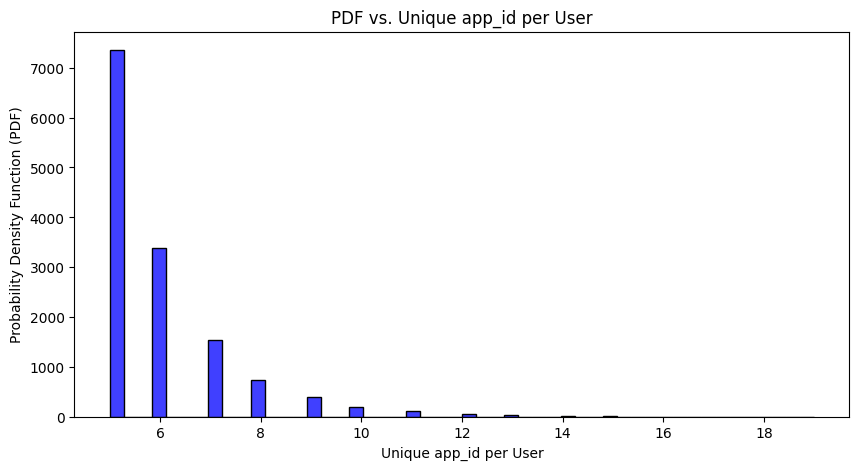

In [35]:
def plot_pdf(df_recs):

  # Count the number of unique app_id per user
  app_count_per_user = df_recs.groupby('user_id')['app_id'].nunique()

  # Plot the PDF vs. unique app_id
  plt.figure(figsize=(10, 5))
  sns.histplot(data=app_count_per_user, kde=False, bins=50, color='blue')
  plt.title('PDF vs. Unique app_id per User')
  plt.xlabel('Unique app_id per User')
  plt.ylabel('Probability Density Function (PDF)')
  plt.show()

# Function call
plot_pdf(df_recs_filt)

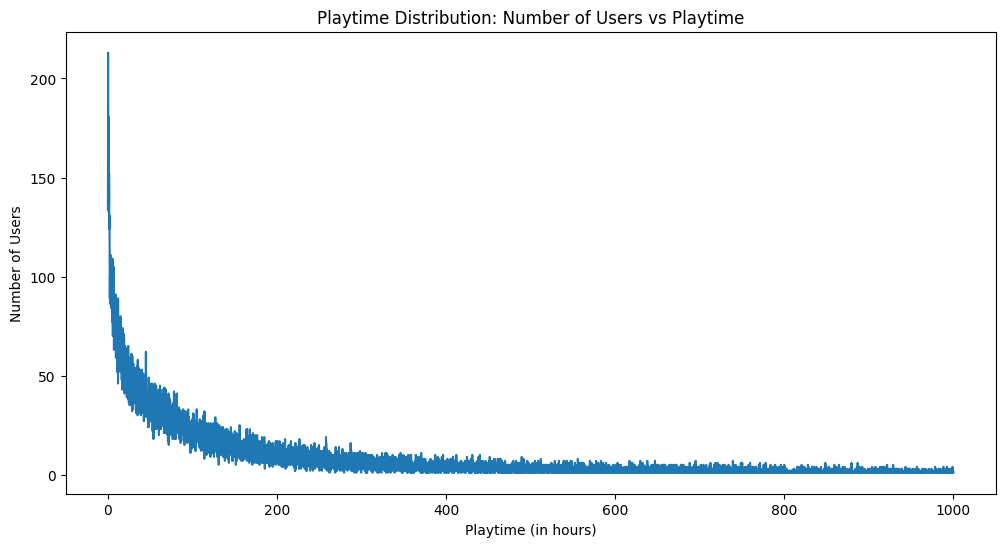

In [36]:
def plot_playtime_distribution(df_recs):

  # Group data by playtime hours and count the number of users
  playtime_user_count = df_recs.groupby('hours_played')['user_id'].count().reset_index()

  # Plot the playtime distribution
  plt.figure(figsize=(12, 6))
  sns.lineplot(data=playtime_user_count, x='hours_played', y='user_id')
  plt.title('Playtime Distribution: Number of Users vs Playtime')
  plt.xlabel('Playtime (in hours)')
  plt.ylabel('Number of Users')
  plt.show()

# Function call
plot_playtime_distribution(df_recs_filt)

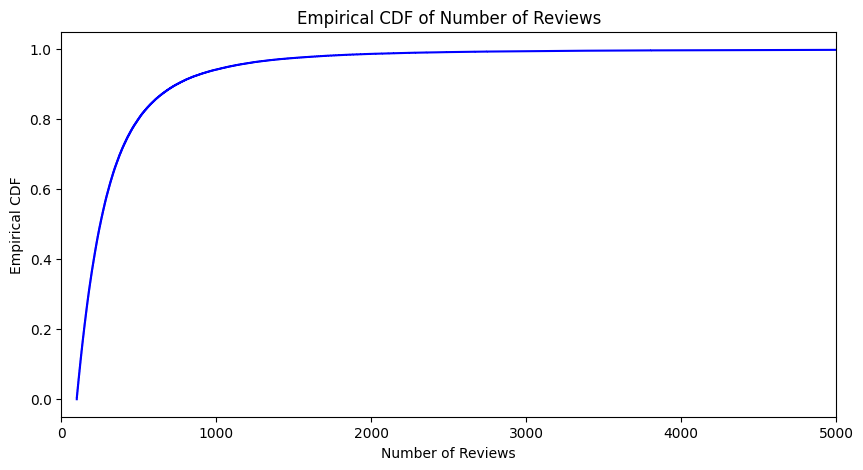

In [37]:
def plot_cdf(df_users):
  # Calculate the empirical CDF
  df_users_sorted = df_users_filt.sort_values(by='games_played')
  cumulative_prob = np.arange(1, len(df_users_sorted) + 1) / len(df_users_sorted)

  # Plot the empirical CDF vs number of reviews
  plt.figure(figsize=(10, 5))
  plt.plot(df_users_sorted['games_played'], cumulative_prob, color='blue')
  plt.title('Empirical CDF of Number of Reviews')
  plt.xlabel('Number of Reviews')
  plt.ylabel('Empirical CDF')
  plt.xlim(0, 5000)

  plt.show()

# Function call
plot_cdf(df_users)

### Determine Memory Requirements

In [38]:
class HaltExecution(Exception):
    pass

In [39]:
# Print total, available, used, and percentage of used memory
def print_system_memory_info():
    
    # Get the virtual memory object
    memory_info = psutil.virtual_memory()

    print(f"Total memory: {memory_info.total / (1024 ** 3):.2f} GB")
    print(f"Available memory: {memory_info.available / (1024 ** 3):.2f} GB")
    print(f"Used memory: {memory_info.used / (1024 ** 3):.2f} GB")
    print(f"Memory usage percentage: {memory_info.percent}%\n")
    
    return memory_info

In [40]:
def estimate_memory_consumption(steam_data, test_size=0.2, rating_metric='is_recommended', verbose = True):
    
    df = steam_data['recs']
    
    memory_per_cell = {
        "int8": 1, "uint8": 1, "int16": 2, "uint16": 2, "int32": 4, "uint32": 4,
        "int64": 8, "uint64": 8, "float16": 2, "float32": 4, "float64": 8,
        "complex64": 8, "complex128": 16, "object": 8, "bool": 1,
    }

    unique_users = round(len(df['user_id'].unique()) * (1-test_size))
    unique_items = round(len(df['app_id'].unique()) * (1-test_size))
    
    total_cells_user_item = unique_users * unique_items
    total_cells_user_user = unique_users * unique_users
    total_cells_item_item = unique_items * unique_items

    dtype_str = str(df[rating_metric].dtype)
    
    if dtype_str in memory_per_cell:
        
        total_memory_user_item = total_cells_user_item * memory_per_cell[dtype_str]
        total_memory_user_user = total_cells_user_user * memory_per_cell[dtype_str]
        total_memory_iem_item = total_cells_item_item * memory_per_cell[dtype_str]
        
        memory_gb_user_item = total_memory_user_item / (1024 ** 3)
        memory_gb_user_user = total_memory_user_user / (1024 ** 3)
        memory_gb_item_item = total_memory_iem_item / (1024 ** 3)
        
        if verbose:
            print("###############################")
            print("####  MEMORY REQUIREMENTS  ####")
            print("###############################\n")

            print(f"Estimated Memory Consumption for Training Set ({(1-test_size)*100}%):")
            print(f"User-Item Matrix: ({unique_users}, {unique_items}) => {total_cells_user_item} total cells => {memory_gb_user_item:.4f} GB")
            print(f"User-User Matrix: ({unique_users}, {unique_users}) => {total_cells_user_user} total cells => {memory_gb_user_user:.4f} GB")
            print(f"Item-Item Matrix: ({unique_items}, {unique_items}) => {total_cells_item_item} total cells => {memory_gb_item_item:.4f} GB")
        
        # Get the virtual memory object
        memory_info = psutil.virtual_memory()

        if memory_gb_user_user >= memory_info.total / (1024 ** 3):
            print('<<< WARNING >>>\nRequired memory may exceed total memory.\n')
            print_system_memory_info()
            user_input = input("Do you want to proceed? (y/n): ")
            if user_input.lower() == "n": raise HaltExecution("Stopping the execution.")
        elif memory_gb_user_user >= memory_info.available / (1024 ** 3):
            print('<<< WARNING >>>\nRequired memory may exceed available memory.\n')
            print_system_memory_info()
            user_input = input("Do you want to proceed? (y/n): ")
            if user_input.lower() == "n": raise HaltExecution("Stopping the execution.")

    return

# Function call
estimate_memory_consumption(steam_data_filt, test_size=0.2)

###############################
####  MEMORY REQUIREMENTS  ####
###############################

Estimated Memory Consumption for Training Set (80.0%):
User-Item Matrix: (14541, 529) => 7692189 total cells => 0.0072 GB
User-User Matrix: (14541, 14541) => 211440681 total cells => 0.1969 GB
Item-Item Matrix: (529, 529) => 279841 total cells => 0.0003 GB


In [41]:
# Save all fuctions into .py file for other notebooks to access
util.save_funcs(NOTEBOOK_PATH, FUNCTIONS_DIR)